# Numerical experiments

In [1]:
import sys
sys.path.append('../')
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import spams
from PIL import Image
from src.utils_dgmca import divisorGenerator
from src.utils_dgmca import Make_Experiment_GG
from src.utils_dgmca import mad
from src.misc_dgmca import *
from src.DGMCA import DGMCA as dgmca
from src.DGMCA_euclidean import DGMCA_euclidean
from src.GMCA import GMCA as gmca
import copy as cp
from tqdm import tqdm
import time

In [46]:
data_path = 'data/'
plots_path = 'plots/'

totalSize = 10000 #10000 # Number of samples for each observation/source

# For the batch sizes: Use all the divisors of totalSize bigger than minSizeBlock
# Or you can define the list manually by changing the array: divisors
minSizeBlock = 20
divisors = list(divisorGenerator(totalSize))
divisors = np.array(divisors)
divisors = divisors[divisors>=minSizeBlock]

# Define your own list of batch sizes
#divisors = np.array([  20])
#divisors = np.array([  50, 100, 200,  500, 1000])
divisors = np.array([  20, 50, 100, 200,  400,   500,   1000,  2000])
#divisors = np.array([  100,   125,   200,   250,   400,   500,   625,  1000,  1250, 2000, 2500])


n_s = 5 # Number of sources
n_obs = 20 # Number of observations
rho = 0.5 # Generalized Gaussian generation parameter
alpha_init = 2. # Alpha parameter for the thresholding strategy

numIts = 1 # Number of repetitions of the experiment

CA_DGMCA = np.zeros([2,len(divisors),numIts])
CA_DGMCA_naive = np.zeros([2,len(divisors),numIts])
CA_DGMCA_euclidean = np.zeros([2,len(divisors),numIts])
CA_ODL = np.zeros([2,len(divisors),numIts])
CA_GMCA = np.zeros([2,numIts])
time_GMCA = np.zeros([numIts])
time_DGMCA = np.zeros([len(divisors),numIts])
time_DGMCA_naive = np.zeros([len(divisors),numIts])
time_DGMCA_euclidean = np.zeros([len(divisors),numIts])
time_ODL = np.zeros([len(divisors),numIts])

cnt_zeros = 0

# Recapitulative of the chosen parameters
print('*******************************************')
print('totalSize: ' + str(totalSize))
print('divisors: ' + str(divisors))
print('numIts: ' + str(numIts))
print('rho: ' + str(rho))
print('alpha_init: ' + str(alpha_init))
print('n_s: ' + str(n_s))
print('n_obs: ' + str(n_obs))
print('*******************************************')

# Define the saving name for the results
title_str = "test_basic_" + "_totalSize_" + str(totalSize) + "_numDivisors_" + str(len(divisors))+ "_n_obs_" + str(n_obs) \
    + "_n_s_" + str(n_s) + "_numIts_" + str(numIts)

print("Test saving name:")
print(title_str)
print('*******************************************')

*******************************************
totalSize: 10000
divisors: [  20   50  100  200  400  500 1000 2000]
numIts: 1
rho: 0.5
alpha_init: 2.0
n_s: 5
n_obs: 20
*******************************************
Test saving name:
test_basic__totalSize_10000_numDivisors_8_n_obs_20_n_s_5_numIts_1
*******************************************


In [47]:
def DGMCA_naive(X,n_s,sizeBlock,A0):
    
    m = X.shape[0]
    t = X.shape[1]
    n_blocks = np.floor(t/sizeBlock).astype(int)
    
    A_block = np.zeros([m,n_s,n_blocks])
    S_hat = np.zeros([n_s,n_blocks*sizeBlock])
    w_FM = np.zeros([n_s,n_blocks])
    
    # Solve each block with the GMCA algorithm
    for it in range(n_blocks):
        
        X_mini = X[:,it*sizeBlock:(it+1)*sizeBlock]
        result = gmca(X_mini,n=n_s,maxts = 7,mints=3,nmax=100,L0=1,UseP=1,verb=0,Init=0,\
            Aposit=False,BlockSize= None,NoiseStd=[],IndNoise=[],Kmax=1.,AInit=None,tol=1e-6,threshOpt=1\
            ,SCOpt=1)
        A_mini = result['mixmat']
        S_mini = result['sources']
        
        A_block[:,:,it] = A_mini
        S_hat[:,it*sizeBlock:(it+1)*sizeBlock] = S_mini
        
        Ra = np.dot(A_mini.T,A_mini)
        Ua,Sa,Va = np.linalg.svd(Ra)
        Sa[Sa < np.max(Sa)*1e-9] = np.max(Sa)*1e-9
        iRa = np.dot(Va.T,np.dot(np.diag(1./Sa),Ua.T))
        piA = np.dot(iRa,A_mini.T)
        
        piA_normF2 = np.sum(np.diag(np.dot(piA.T,piA)))
        sigma_X_j = mad(X_mini)*1.
        
        for it2 in range(n_s):
            St = S_mini[it2,:]
            w_FM[it2,it] = np.sum(St**2)/((len(St)*1.)*(sigma_X_j*piA_normF2))
        
        
    # Aggregate the different A matrices
    Aref = A_block[:,:,0] # A0 
    A_mean = DGMCA_FrechetMean(As = A_block, Aref = Aref, w = w_FM)
    
    return A_mean, S_hat
    

In [48]:
for it_n in tqdm(range(numIts)):

    X,X0,A0,S0,N = Make_Experiment_GG(n_s=n_s,n_obs=n_obs,t_samp=totalSize,noise_level=5.0,\
                                      dynamic=0,CondNumber=1,alpha=rho)
    
    X_ODL = np.asfortranarray(cp.deepcopy(X))
    
    time1 = time.time()
    Results_sB_totSC = gmca(cp.deepcopy(X),n=n_s,maxts = 7,mints=3,nmax=100,L0=1,UseP=1,verb=0,Init=0,\
                Aposit=False,BlockSize= None,NoiseStd=[],IndNoise=[],Kmax=1.,AInit=None,tol=1e-6,threshOpt=1\
                ,SCOpt=1)
    time_GMCA[it_n] = time.time() - time1
    A_sB_totSC = Results_sB_totSC['mixmat']
    S_sB_totSC = Results_sB_totSC['sources']
    crit_sB_totSC = EvalCriterion_eval(A0,S0,A_sB_totSC,S_sB_totSC) 
    CA_GMCA[0,it_n] = crit_sB_totSC['ca_mean']
    CA_GMCA[1,it_n] = crit_sB_totSC['ca_med']


    for it1 in range(len(divisors)):

        numBlock = totalSize/divisors[it1]
        sizeBlock = divisors[it1]
        
        # DGMCA
        time1 = time.time()
        Results_sB0 = dgmca(cp.deepcopy(X),n=n_s,mints=3,nmax=100,L0=1,verb=0,Init=0,\
                            BlockSize= None,Kmax=1.,AInit=None,tol=1e-6,subBlockSize=sizeBlock,\
                            SCOpt=1,alphaEstOpt=0,alpha_exp=alpha_init)
        # alphaEstOpt can be put to 1 to have a more precise result.
        time_DGMCA[it1,it_n] = time.time() - time1
        A_sB0 = Results_sB0['mixmat']
        S_sB0 = Results_sB0['sources']
        crit_sB0 = EvalCriterion_eval(A0,S0,A_sB0,S_sB0) 
        CA_DGMCA[0,it1,it_n] = crit_sB0['ca_mean']
        CA_DGMCA[1,it1,it_n] = crit_sB0['ca_med']
        
        # ODL (Online Dictionary Learning)
        param = { 'K' : n_s, 'lambda1' : 0.03, 'numThreads' : 4, 'batchsize' : sizeBlock,
        'iter' : 1000, 'mode' : 0, 'modeD' : 0}
        time1 = time.time()
        A_ODL = spams.trainDL(X_ODL,**param)
        time_ODL[it1,it_n] = time.time() - time1
        crit_ODL = EvalCriterion_eval(A0,S0,A_ODL,S0) 
        CA_ODL[0,it1,it_n] = crit_ODL['ca_mean']
        CA_ODL[1,it1,it_n] = crit_ODL['ca_med']     
        
        try:
            # DGMCA naive
            time1 = time.time()
            A_naive, S_naive = DGMCA_naive(cp.deepcopy(X),n_s,sizeBlock,A0)
            time_DGMCA_naive[it1,it_n] = time.time() - time1
            crit_naive = EvalCriterion_eval(A0,S0,A_naive,S_naive) 
            CA_DGMCA_naive[0,it1,it_n] = crit_naive['ca_mean']
            CA_DGMCA_naive[1,it1,it_n] = crit_naive['ca_med']
        except:
            cnt_zeros += 1
            pass
        
        # DGMCA euclidean
        time1 = time.time()
        Results_euclidean = DGMCA_euclidean(cp.deepcopy(X),n=n_s,mints=3,nmax=100,L0=1,verb=0,Init=0,\
                            BlockSize= None,Kmax=1.,AInit=None,tol=1e-6,subBlockSize=sizeBlock,\
                            SCOpt=1,alphaEstOpt=0,alpha_exp=alpha_init)
        time_DGMCA_euclidean[it1,it_n] = time.time() - time1
        A_euclidean = Results_euclidean['mixmat']
        S_euclidean = Results_euclidean['sources']
        crit_euclidean = EvalCriterion_eval(A0,S0,A_euclidean,S_euclidean) 
        CA_DGMCA_euclidean[0,it1,it_n] = crit_euclidean['ca_mean']
        CA_DGMCA_euclidean[1,it1,it_n] = crit_euclidean['ca_med']
        
        




  0%|          | 0/1 [00:00<?, ?it/s]


100%|██████████| 1/1 [07:03<00:00, 423.85s/it]




In [49]:
# Some calculations to print afterwards

# Time
time_GMCA_mean = np.mean(time_GMCA,axis=0)
time_GMCA_total = np.sum(time_GMCA, axis=0)

time_DGMCA_mean = np.mean(time_DGMCA,axis=1)
time_DGMCA_mean = np.mean(time_DGMCA_mean)
time_DGMCA_total = np.sum(time_DGMCA,axis=1)
time_DGMCA_total = np.sum(time_DGMCA_total)

time_ODL_mean = np.mean(time_ODL,axis=1)
time_ODL_mean = np.mean(time_ODL_mean)
time_ODL_total = np.sum(time_ODL,axis=1)
time_ODL_total = np.sum(time_ODL_total)

time_DGMCA_naive_mean = np.mean(time_DGMCA_naive,axis=1)
time_DGMCA_naive_mean = np.mean(time_DGMCA_naive_mean)
time_DGMCA_naive_total = np.sum(time_DGMCA_naive,axis=1)
time_DGMCA_naive_total = np.sum(time_DGMCA_naive_total)

time_DGMCA_euclidean_mean = np.mean(time_DGMCA_euclidean,axis=1)
time_DGMCA_euclidean_mean = np.mean(time_DGMCA_euclidean_mean)
time_DGMCA_euclidean_total = np.sum(time_DGMCA_euclidean,axis=1)
time_DGMCA_euclidean_total = np.sum(time_DGMCA_euclidean_total)


# Results
CA_GMCA_mean = np.mean(CA_GMCA,axis=1)
CA_DGMCA_mean = np.mean(CA_DGMCA,axis=2)
CA_ODL_mean = np.mean(CA_ODL,axis=2)
CA_DGMCA_naive_mean = np.mean(CA_DGMCA_naive,axis=2)
CA_DGMCA_euclidean_mean = np.mean(CA_DGMCA_euclidean,axis=2)
CA_GMCA_med = np.median(CA_GMCA,axis=1)
CA_DGMCA_med = np.median(CA_DGMCA,axis=2)
CA_ODL_med = np.median(CA_ODL,axis=2)
CA_DGMCA_naive_med = np.median(CA_DGMCA_naive,axis=2)
CA_DGMCA_euclidean_med = np.median(CA_DGMCA_euclidean,axis=2)

dB_CA_GMCA_mean = -10*np.log10(CA_GMCA_mean)
dB_CA_DGMCA_mean = -10*np.log10(CA_DGMCA_mean)
dB_CA_ODL_mean = -10*np.log10(CA_ODL_mean)
dB_CA_DGMCA_naive_mean = -10*np.log10(CA_DGMCA_naive_mean)
dB_CA_DGMCA_euclidean_mean = -10*np.log10(CA_DGMCA_euclidean_mean)
dB_CA_GMCA_med = -10*np.log10(CA_GMCA_med)
dB_CA_DGMCA_med = -10*np.log10(CA_DGMCA_med)
dB_CA_ODL_med = -10*np.log10(CA_ODL_med)
dB_CA_DGMCA_naive_med = -10*np.log10(CA_DGMCA_naive_med)
dB_CA_DGMCA_euclidean_med = -10*np.log10(CA_DGMCA_euclidean_med)


# Save variables
title_CA_DGMCA = data_path + 'CA_DGMCA' + title_str  
np.save(title_CA_DGMCA,CA_DGMCA)
title_CA_ODL = data_path + 'CA_ODL' + title_str  
np.save(title_CA_ODL,CA_ODL)
title_CA_DGMCA_naive = data_path + 'CA_DGMCA_naive' + title_str  
np.save(title_CA_DGMCA_naive,CA_DGMCA_naive)
title_CA_DGMCA_euclidean = data_path + 'CA_DGMCA_euclidean' + title_str  
np.save(title_CA_DGMCA_euclidean,CA_DGMCA_euclidean)
title_CA_GMCA = data_path + 'CA_GMCA' + title_str  
np.save(title_CA_GMCA,CA_GMCA)

In [50]:
# Import
ext = '.npy'
imp_CA_GMCA = np.load(title_CA_GMCA + ext)
imp_CA_DGMCA = np.load(title_CA_DGMCA + ext)
imp_CA_ODL = np.load(title_CA_ODL + ext)
imp_CA_DGMCA_naive = np.load(title_CA_DGMCA_naive + ext)
imp_CA_DGMCA_euclidean = np.load(title_CA_DGMCA_euclidean + ext)

# Mean over the experiments
imp_CA_GMCA = np.mean(imp_CA_GMCA,axis=1) # Over the batch sizes
imp_CA_DGMCA = np.mean(imp_CA_DGMCA,axis=2) # Over the iterations
imp_CA_DGMCA_naive = np.mean(imp_CA_DGMCA_naive,axis=2) # Over the iterations
imp_CA_DGMCA_euclidean = np.mean(imp_CA_DGMCA_euclidean,axis=2) # Over the iterations
imp_CA_ODL = np.mean(imp_CA_ODL,axis=2) # Over the iterations

# Median over the experiments
#imp_CA_GMCA = np.median(imp_CA_GMCA,axis=1) # Over the batch sizes
#imp_CA_DGMCA = np.median(imp_CA_DGMCA,axis=2) # Over the iterations

# To dB
log_imp_CA_GMCA = -10*np.log10(imp_CA_GMCA)
log_imp_CA_DGMCA = -10*np.log10(imp_CA_DGMCA)
log_imp_CA_ODL = -10*np.log10(imp_CA_ODL)
log_imp_CA_DGMCA_naive = -10*np.log10(imp_CA_DGMCA_naive)
log_imp_CA_DGMCA_euclidean = -10*np.log10(imp_CA_DGMCA_euclidean)

Divisors plotted:
[  20   50  100  200  400  500 1000]


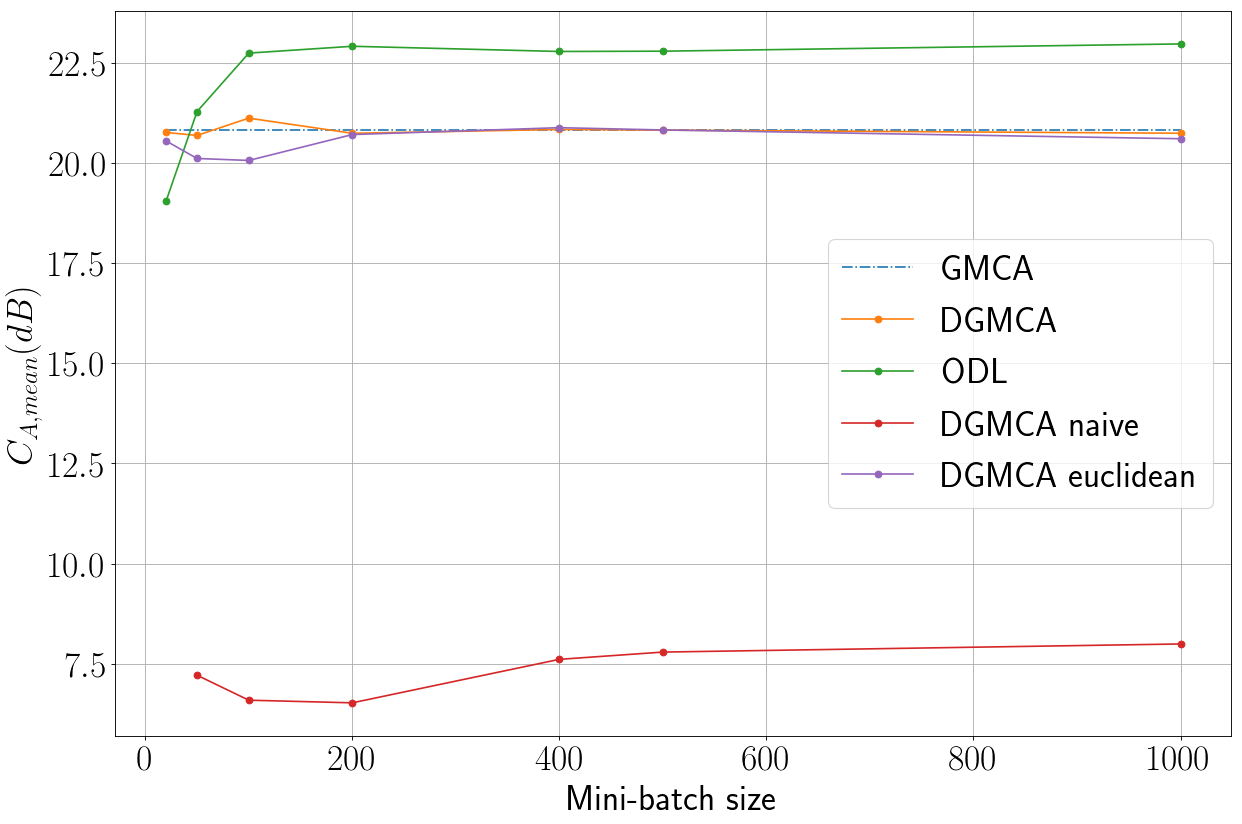

In [51]:
# Use the mean or the median over the CA 
type_ca = 0# 0 = CA_mean // 1 = CA_median
n_div = 7#len(divisors)

print('Divisors plotted:')
print(divisors[0:n_div])

matplotlib.rcParams.update({'font.size': 32}) # 23
fig=plt.figure(figsize=(18, 12), dpi= 80, facecolor='w', edgecolor='k')
plt.rc('text', usetex=True)

plt.plot(divisors[0:n_div], log_imp_CA_GMCA[type_ca]*np.ones(len(divisors[0:n_div])), '-.', label=r'GMCA')
plt.plot(divisors[0:n_div], log_imp_CA_DGMCA[type_ca,0:n_div], '-o', label=r'DGMCA')
plt.plot(divisors[0:n_div], log_imp_CA_ODL[type_ca,0:n_div], '-o', label=r'ODL')
plt.plot(divisors[1:n_div], log_imp_CA_DGMCA_naive[type_ca,1:n_div], '-o', label=r'DGMCA naive')
plt.plot(divisors[0:n_div], log_imp_CA_DGMCA_euclidean[type_ca,0:n_div], '-o', label=r'DGMCA euclidean')

plt.xlabel('Mini-batch size')
if type_ca == 0:
    plt.ylabel(r'$C_{A,mean}(dB)$')
elif type_ca == 1:
    plt.ylabel(r'$C_{A,med}(dB)$')
plt.grid()
plt.legend()
plt.show()

title_str_pdf = plots_path + title_str + ".pdf"
fig.savefig(title_str_pdf, bbox_inches='tight')